In [1]:
import sys
!{sys.executable} -m pip install pymongo
!{sys.executable} -m pip install pyyaml
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install moment
import os
print(os.getcwd())

/Users/drewgregory/JupyterNotebooks/habitlab-data-analysis


In [2]:
# Get Mongo database
from yaml import load
from pymongo import MongoClient
secret = load(open("../../.getsecret.yaml"))

client = MongoClient(secret["MONGODB_URI"])
db = client[secret["DB_NAME"]]

In [3]:
# Get all synced accounts and their respective users.
import urllib.request as req
import json
accounts = json.loads(req.urlopen("http://localhost:5000/synced_emails").read().decode("utf-8"))
counter = 0

In [4]:
# TOTAL AVERAGE COMPARISONS: Organize sessions by goal and frequent vs. infrequent for Android
goals = {}
for account in accounts:
    for user in account["android"]:
        for session in db[user + "_sessions"].find({"enabled": True}):
            domain = session["domain"]
            if domain not in goals:
                goals[domain] = {"freq":[], "infreq":[]}
            if session["frequent"]:
                goals[domain]["freq"].append(session)
            else:
                goals[domain]["infreq"].append(session)

In [5]:
# Graph these comparisons
import matplotlib.pyplot as pyplot
from statistics import mean, median
from scipy.stats import sem, norm 
# Now show graphs for each domain to compare frequent sessions vs infrequent sessions.
domain_stats = []
for domain in goals:
    if len(goals[domain]["freq"]) > 0 and len(goals[domain]["infreq"]) > 0:
        freq_durations = [session["duration"] for session in goals[domain]["freq"]]
        freq_avg = mean(freq_durations)
        freq_err = sem(freq_durations)
        infreq_durations = [session["duration"] for session in goals[domain]["infreq"]] 
        infreq_avg = mean(infreq_durations)
        infreq_err = sem(infreq_durations)
        domain_stats.append({"domain": domain, "freq": freq_avg, 
                             "infreq": infreq_avg, "freq_pts":len(goals[domain]["freq"]),
                            "infreq_pts":len(goals[domain]["infreq"]), "freq_err": freq_err,
                            "infreq_err": infreq_err})

        domain_stats = sorted(domain_stats, key=lambda stat: int(stat["freq_pts"] + stat["infreq_pts"]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2
com.clowngames.shootersio with 1 freq points  and 1 infreq pts
freq avg: 136
infreq avg: 107
2
org.isoron.uhabits with 1 freq points  and 1 infreq pts
freq avg: 4
infreq avg: 6
2
tv.twitch.android.app with 1 freq points  and 1 infreq pts
freq avg: 24
infreq avg: 6
2
com.king.candycrushsodasaga with 1 freq points  and 1 infreq pts
freq avg: 348
infreq avg: 142
3
mobi.societegenerale.mobile.lappli with 2 freq points  and 1 infreq pts
freq avg: 47
infreq avg: 6
3
cc.forestapp with 1 freq points  and 2 infreq pts
freq avg: 3
infreq avg: 1
4
org.ebookdroid with 3 freq points  and 1 infreq pts
freq avg: 68.66666666666667
infreq avg: 426
4
com.crowdstar.covetHome with 1 freq points  and 3 infreq pts
freq avg: 54
infreq avg: 63
4
com.magoosh.gre.quiz.vocabulary with 3 freq points  and 1 infreq pts
freq avg: 32
infreq avg: 1
4
ch.alpsoft.qoqa.ui with 2 freq points  and 2 infreq pts
freq avg: 23.5
infreq avg: 13.5
5
com.globalegrow.app.gearbest with 2 freq points  and 3 infreq pts
freq avg: 18

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


257
com.ideashower.readitlater.pro with 82 freq points  and 175 infreq pts
freq avg: 64.51219512195122
infreq avg: 99.68571428571428
272
com.facebook.lite with 75 freq points  and 197 infreq pts
freq avg: 50.14666666666667
infreq avg: 57.380710659898476
274
com.nhn.android.band with 239 freq points  and 35 infreq pts
freq avg: 41.14225941422594
infreq avg: 66.05714285714286
306
com.evernote with 199 freq points  and 107 infreq pts
freq avg: 74.68341708542714
infreq avg: 277.94392523364485
308
com.sina.weibo with 68 freq points  and 240 infreq pts
freq avg: 69.79411764705883
infreq avg: 74.175
336
com.gm99.clx with 239 freq points  and 97 infreq pts
freq avg: 186.38912133891213
infreq avg: 205.97938144329896
371
com.grindrapp.android with 4 freq points  and 367 infreq pts
freq avg: 37
infreq avg: 12.561307901907357
447
org.telegram.messenger with 251 freq points  and 196 infreq pts
freq avg: 36.832669322709165
infreq avg: 35.93877551020408
447
com.onelouder.baconreader with 116 freq poi

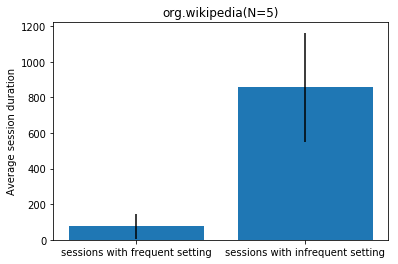

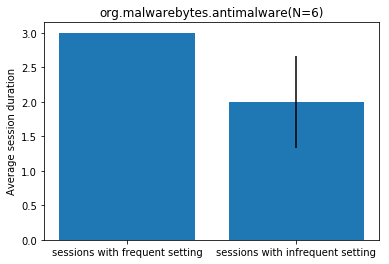

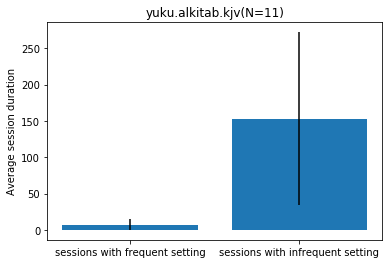

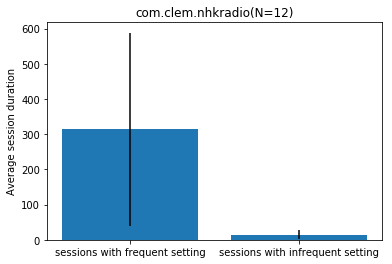

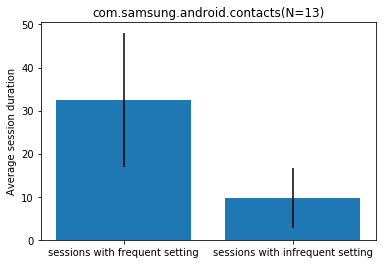

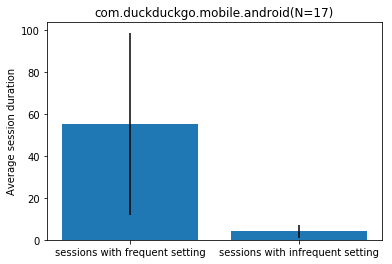

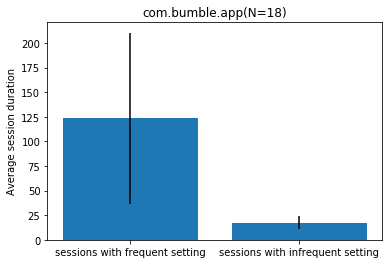

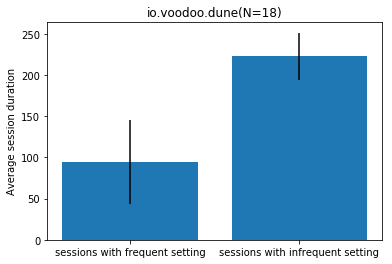

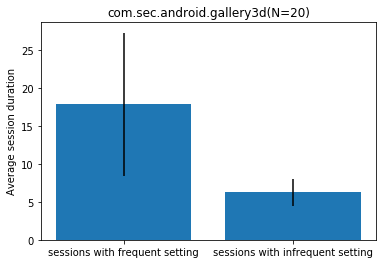

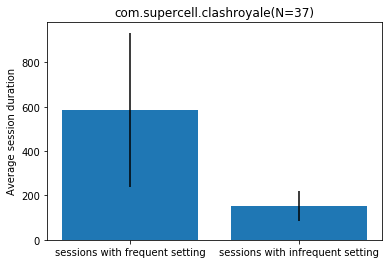

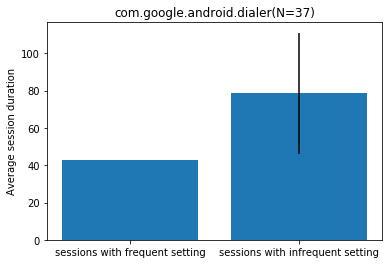

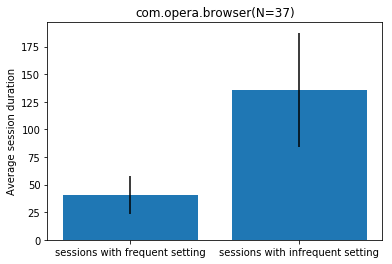

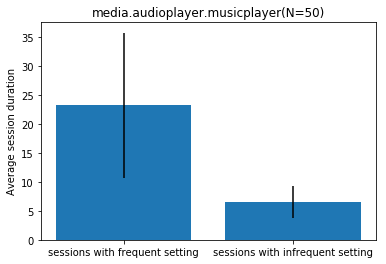

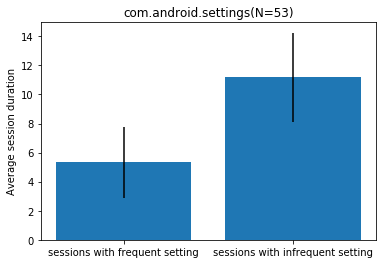

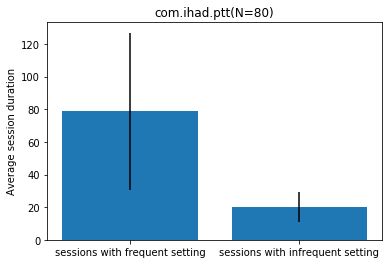

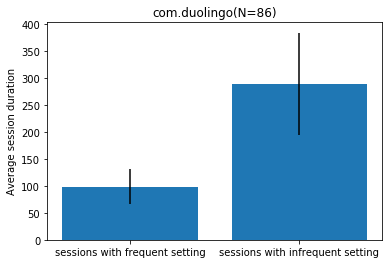

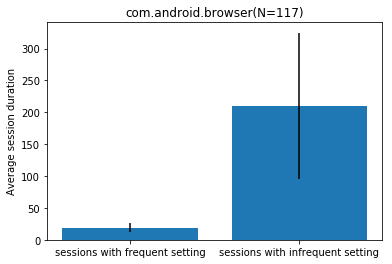

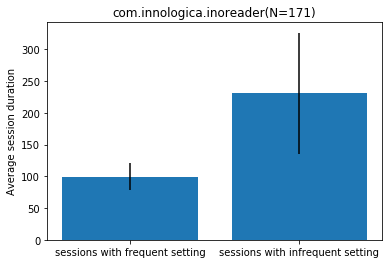

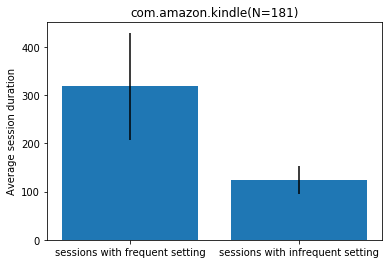

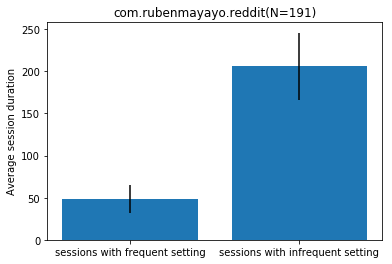

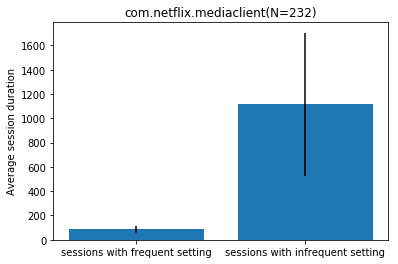

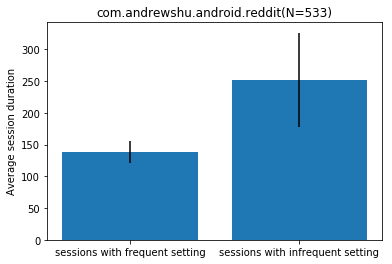

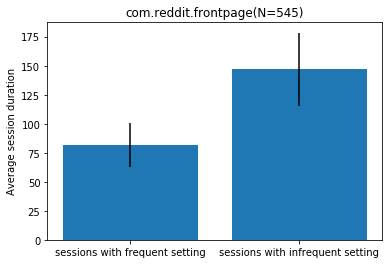

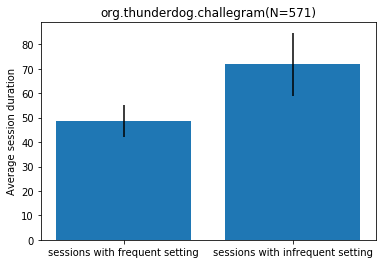

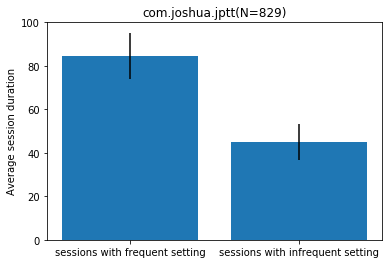

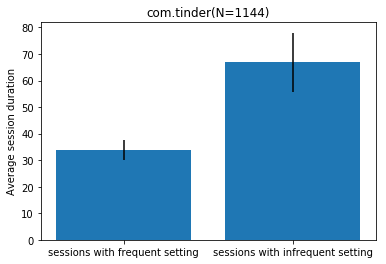

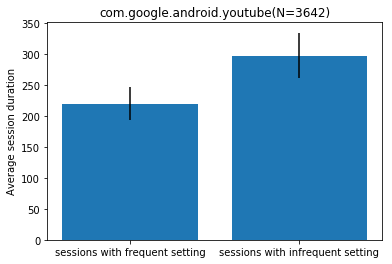

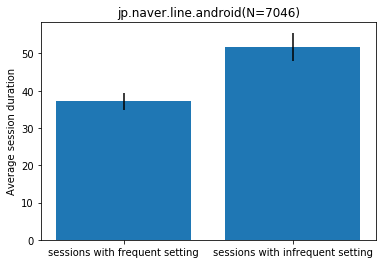

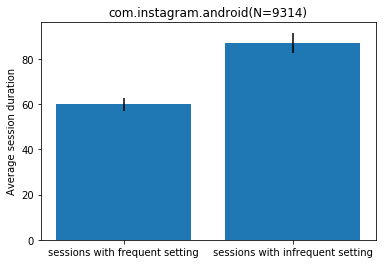

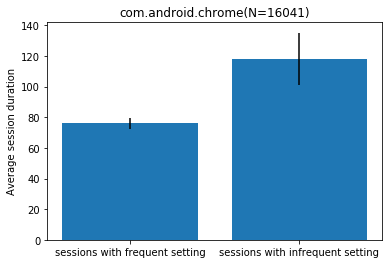

In [6]:
for stat in domain_stats:
    print(int(stat["freq_pts"] + stat["infreq_pts"]))
    print(stat['domain'] + " with " + str(stat["freq_pts"]) + " freq points " + " and " + str(stat["infreq_pts"]) + " infreq pts")
    print("freq avg: " + str(stat["freq"]))
    print("infreq avg: " + str(stat["infreq"]))
    # If there is a statistically significant difference (95% conf intervals don't overlap), we will show the graph.
    if stat["freq"] - 1.64 * stat["freq_err"] > stat["infreq"] + 1.64 * stat["infreq_err"] or stat["infreq"] -  1.64 * stat["infreq_err"] > stat["freq"] + 1.64 * stat["freq_err"]:
        counter += 1
        pyplot.figure(counter)
        pyplot.title(stat["domain"] + "(N="+ str(int(stat["freq_pts"] + stat["infreq_pts"]))+ ")")
        pyplot.ylabel('Average session duration')
        pyplot.bar(["sessions with frequent setting", "sessions with infrequent setting"], [stat["freq"], stat["infreq"]] , .8, yerr=[1.64 * stat["freq_err"], 1.64 * stat["infreq_err"]])
    

In [1]:
# Within user T-Test on freq vs infreq duration length per domain
improvement_stats = {}
for account in accounts:
    for user in account["android"]:
        # We now want to see if they have goals that have alternated from freq to infreq.
        goals={}
        for session in db[user + "_sessions"].find({"enabled": True}):
            domain = session["domain"]
            if domain not in goals:
                goals[domain] = {"freq_duration":0, "freq_count": 0, "infreq_duration":0, "infreq_count":0}
            if session["frequent"]:
                goals[domain]["freq_duration"] += session["duration"]
                goals[domain]["freq_count"] += 1
            else:
                goals[domain]["infreq_duration"] += session["duration"]
                goals[domain]["infreq_count"] += 1
        # Compute averages
        for domain in goals:
            if goals[domain]["freq_count"] > 30 and goals[domain]["infreq_count"] > 30:
                if domain not in improvement_stats:
                    improvement_stats[domain] = {"freq": [], "infreq": []}
                freq_avg = goals[domain]["freq_duration"]/goals[domain]["freq_count"]
                infreq_avg = goals[domain]["infreq_duration"]/goals[domain]["infreq_count"]
                improvement_stats[domain]["freq"].append(freq_avg)
                improvement_stats[domain]["infreq"].append(infreq_avg)
from scipy.stats import ttest_ind
for domain in improvement_stats:
    if len(improvement_stats[domain]["freq"]) > 10:
        print(domain)
        print(str(improvement_stats[domain]['freq']) + str(improvement_stats[domain]["infreq"]))
    print("freq: " + str(len(improvement_stats[domain]["freq"])) + "infreq: " + str(len(improvement_stats[domain]["infreq"])))

    results = ttest_ind(improvement_stats[domain]["freq"], improvement_stats[domain]["infreq"])
    print(str(results))

NameError: name 'accounts' is not defined

38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
37
24
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
37
37
37
37
37
37
37
37
37
37
37
37
37
37
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
37
37
37
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
26
37
37
37
37
37
37
37
37
37
37
28
28
28
28
28
28
28
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
34
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
37
37
37
37
37
37
37
37
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
29
29
29
29
29
29
29
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
37
37
37
37
37
37
37
37
37
37
37
37
37
38
38
38
37
37
38
38
38
38
38
37
3

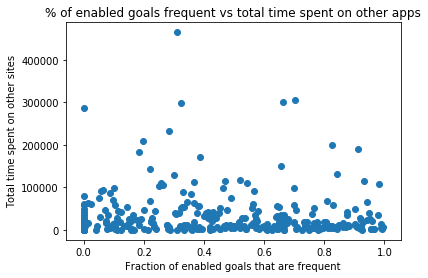

In [9]:
# Goal: fraction of freq goals vs. total time spent
frac = []
total_time_other = []
total_users = 0
users_with_bad_domains = 0
for account in accounts:
    for user in account["android"]:
        week_stats = {}
        total_users += 1
        for session in db[user+ "_sessions"].find({"isoWeek": {"$exists": True}, "frequent": {"$exists": True}}):
            iso = session["isoWeek"]
            if iso not in week_stats:
                week_stats[iso] = {"freq": 0, "infreq": 0, "total_time": 0}
            if not session["enabled"]:
                if session["duration"] > 86400:
                    # print(session)
                    users_with_bad_domains += 1
                    continue
                week_stats[iso]["total_time"] += session["duration"]
            elif session["frequent"]:
                week_stats[iso]["freq"] += 1
            else:
                week_stats[iso]["infreq"] += 1
        for iso in week_stats:
            stat = week_stats[iso]
            if (stat["total_time"] > 604800):
                print(str(stat))
            if stat["infreq"] > 0 or stat["infreq"] > 0:
                frac.append(stat["freq"]/(stat["infreq"] + stat["freq"]))
                total_time_other.append(stat["total_time"])
counter += 1
pyplot.figure(counter)
pyplot.title("% of enabled goals frequent vs total time spent on other apps")
pyplot.xlabel("Fraction of enabled goals that are frequent")
pyplot.ylabel("Total time spent on other sites")
pyplot.scatter(frac, total_time_other)
            


In [11]:
from scipy import stats
stats.linregress(frac, total_time_other)

LinregressResult(slope=-7121.674528445417, intercept=37076.51396260677, rvalue=-0.040141014389181, pvalue=0.48418388954368974, stderr=10167.32755266261)

In [12]:
print(str(users_with_bad_domains/total_users))

1.844504021447721


In [ ]:
# Now, let's compare 